In [10]:
## caged_brach
%reload_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

import basedosdados as bd

from geobr import read_municipality, read_state

import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.colors import ListedColormap

import plotly.express as px

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors, cm

import matplotlib.pyplot as plt
import matplotlib
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Montserrat'
from matplotlib.offsetbox import  OffsetImage
import matplotlib.image as image
import matplotlib.ticker as mtick

In [3]:
query = """
WITH caged as (
  SELECT
    ano,
    CONCAT(ano,"-",id_municipio) as id_municipio,
    sigla_uf,
    admitidos_desligados,
    SUBSTR(cnae_2, 1, 2) as divisao_economica,
  FROM `basedosdados-dev.br_me_caged.microdados_antigos`
),

caged2 as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    SAFE_CAST(divisao_economica as INT64) as divisao_economica,
    COUNTIF(admitidos_desligados = 1) as admitidos_total,
    COUNTIF(admitidos_desligados = 2) as desligados_total,
  FROM caged
  GROUP BY 1,2,3,4
  ORDER BY id_municipio, admitidos_total DESC
),

caged3 as (
  SELECT 
      ano,
      id_municipio,
      sigla_uf,
      divisao_economica as id_divisao_economica,
      CASE
            WHEN (divisao_economica>=1  AND divisao_economica<=3)  THEN "AGROPECUÁRIA"
            WHEN (divisao_economica>=5  AND divisao_economica<=9)  THEN "OUTROS"
            WHEN (divisao_economica>=10 AND divisao_economica<=33) THEN "INDÚSTRIAS"
            WHEN (divisao_economica>=35 AND divisao_economica<=35) THEN "OUTROS"
            WHEN (divisao_economica>=36 AND divisao_economica<=39) THEN "OUTROS"
            WHEN (divisao_economica>=41 AND divisao_economica<=43) THEN "CONSTRUÇÃO"
            WHEN (divisao_economica>=45 AND divisao_economica<=47) THEN "COMÉRCIO"
            WHEN (divisao_economica>=49 AND divisao_economica<=53) THEN "TRANSPORTE"
            WHEN (divisao_economica>=55 AND divisao_economica<=56) THEN "OUTROS"
            WHEN (divisao_economica>=58 AND divisao_economica<=63) THEN "OUTROS"
            WHEN (divisao_economica>=64 AND divisao_economica<=66) THEN "OUTROS"
            WHEN (divisao_economica>=68 AND divisao_economica<=68) THEN "OUTROS"
            WHEN (divisao_economica>=69 AND divisao_economica<=75) THEN "OUTROS"
            WHEN (divisao_economica>=77 AND divisao_economica<=82) THEN "OUTROS"
            WHEN (divisao_economica>=84 AND divisao_economica<=84) THEN "OUTROS"
            WHEN (divisao_economica>=85 AND divisao_economica<=85) THEN "OUTROS"
            WHEN (divisao_economica>=86 AND divisao_economica<=88) THEN "OUTROS"
            WHEN (divisao_economica>=90 AND divisao_economica<=93) THEN "OUTROS"
            WHEN (divisao_economica>=94 AND divisao_economica<=96) THEN "OUTROS"
            WHEN (divisao_economica>=97 AND divisao_economica<=97) THEN "OUTROS"
            WHEN (divisao_economica>=99 AND divisao_economica<=99) THEN "OUTROS"
          -- WHEN (divisao_economica>=1  AND divisao_economica<=3)  THEN "AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PESCA E AQÜICULTURA"
          -- WHEN (divisao_economica>=5  AND divisao_economica<=9)  THEN "INDÚSTRIAS EXTRATIVAS"
          -- WHEN (divisao_economica>=10 AND divisao_economica<=33) THEN "INDÚSTRIAS DE TRANSFORMAÇÃO"
          -- WHEN (divisao_economica>=35 AND divisao_economica<=35) THEN "ELETRICIDADE E GÁS"
          -- WHEN (divisao_economica>=36 AND divisao_economica<=39) THEN "ÁGUA, ESGOTO, ATIVIDADES DE GESTÃO DE RESÍDUOS E DESCONTAMINAÇÃO"
          -- WHEN (divisao_economica>=41 AND divisao_economica<=43) THEN "CONSTRUÇÃO"
          -- WHEN (divisao_economica>=45 AND divisao_economica<=47) THEN "COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E MOTOCICLETAS"
          -- WHEN (divisao_economica>=49 AND divisao_economica<=53) THEN "TRANSPORTE, ARMAZENAGEM E CORREIO"
          -- WHEN (divisao_economica>=55 AND divisao_economica<=56) THEN "ALOJAMENTO E ALIMENTAÇÃO"
          -- WHEN (divisao_economica>=58 AND divisao_economica<=63) THEN "INFORMAÇÃO E COMUNICAÇÃO"
          -- WHEN (divisao_economica>=64 AND divisao_economica<=66) THEN "ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS RELACIONADOS"
          -- WHEN (divisao_economica>=68 AND divisao_economica<=68) THEN "ATIVIDADES IMOBILIÁRIAS"
          -- WHEN (divisao_economica>=69 AND divisao_economica<=75) THEN "ATIVIDADES PROFISSIONAIS, CIENTÍFICAS E TÉCNICAS"
          -- WHEN (divisao_economica>=77 AND divisao_economica<=82) THEN "ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEMENTARES"
          -- WHEN (divisao_economica>=84 AND divisao_economica<=84) THEN "ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL"
          -- WHEN (divisao_economica>=85 AND divisao_economica<=85) THEN "EDUCAÇÃO"
          -- WHEN (divisao_economica>=86 AND divisao_economica<=88) THEN "SAÚDE HUMANA E SERVIÇOS SOCIAIS"
          -- WHEN (divisao_economica>=90 AND divisao_economica<=93) THEN "ARTES, CULTURA, ESPORTE E RECREAÇÃO"
          -- WHEN (divisao_economica>=94 AND divisao_economica<=96) THEN "OUTRAS ATIVIDADES DE SERVIÇOS"
          -- WHEN (divisao_economica>=97 AND divisao_economica<=97) THEN "SERVIÇOS DOMÉSTICOS"
          -- WHEN (divisao_economica>=99 AND divisao_economica<=99) THEN "ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUIÇÕES EXTRATERRITORIAIS"
      END AS divisao_economica,
      admitidos_total,
      desligados_total
  FROM caged2
),

caged4 as (
  SELECT event.* FROM (
    SELECT ARRAY_AGG(
      caged3 ORDER BY caged3.admitidos_total DESC LIMIT 1
    )[OFFSET(0)]  event
    FROM caged3 
    # GROUP BY the id you are de-duplicating by
    GROUP BY caged3.id_municipio 
  )
)


SELECT
  ano,
  SAFE_CAST(SUBSTR(id_municipio,6,11) AS INT64) as id_municipio,
  sigla_uf,
  divisao_economica,
  admitidos_total,
  desligados_total
FROM caged4
"""

caged = bd.read_sql(query, billing_project_id='basedosdados-dev')
caged_2019 = caged[caged['ano']==2019]

Downloading: 100%|██████████| 71733/71733 [00:04<00:00, 14770.17rows/s]


In [5]:
# Read all municipalities in the country at a given year
mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)
df = pd.merge(caged_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df = gpd.GeoDataFrame(df)

df_count = caged_2019[['divisao_economica']].copy()
df_count['count'] = 1
df_count = df_count.groupby(by='divisao_economica', as_index=False).sum().sort_values(by='count')


caged_graph=caged[['ano','divisao_economica']]
caged_graph['count']=1
caged_graph = caged_graph.groupby(['ano','divisao_economica'], as_index=False).sum()
caged_graph = caged_graph.sort_values(by=['count'],ascending=False)
caged_graph = caged_graph.pivot_table(columns='divisao_economica',index=['ano'], values='count')
caged_graph = caged_graph.div(caged_graph.sum(axis=1), axis=0)*100
caged_graph = caged_graph.reset_index()

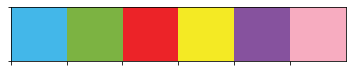

In [8]:
#2605459 Fernando de Noronha
#3205309 Vitoria


px_bar_colors = [
    "#43B7E9",
    "#7cb342",
    "#EC2328",
    "#F4EA24",
    "#86529E",
    "#F7ACC0",
    
]
import seaborn as sns
sns.palplot(px_bar_colors)

<Figure size 2160x2160 with 0 Axes>

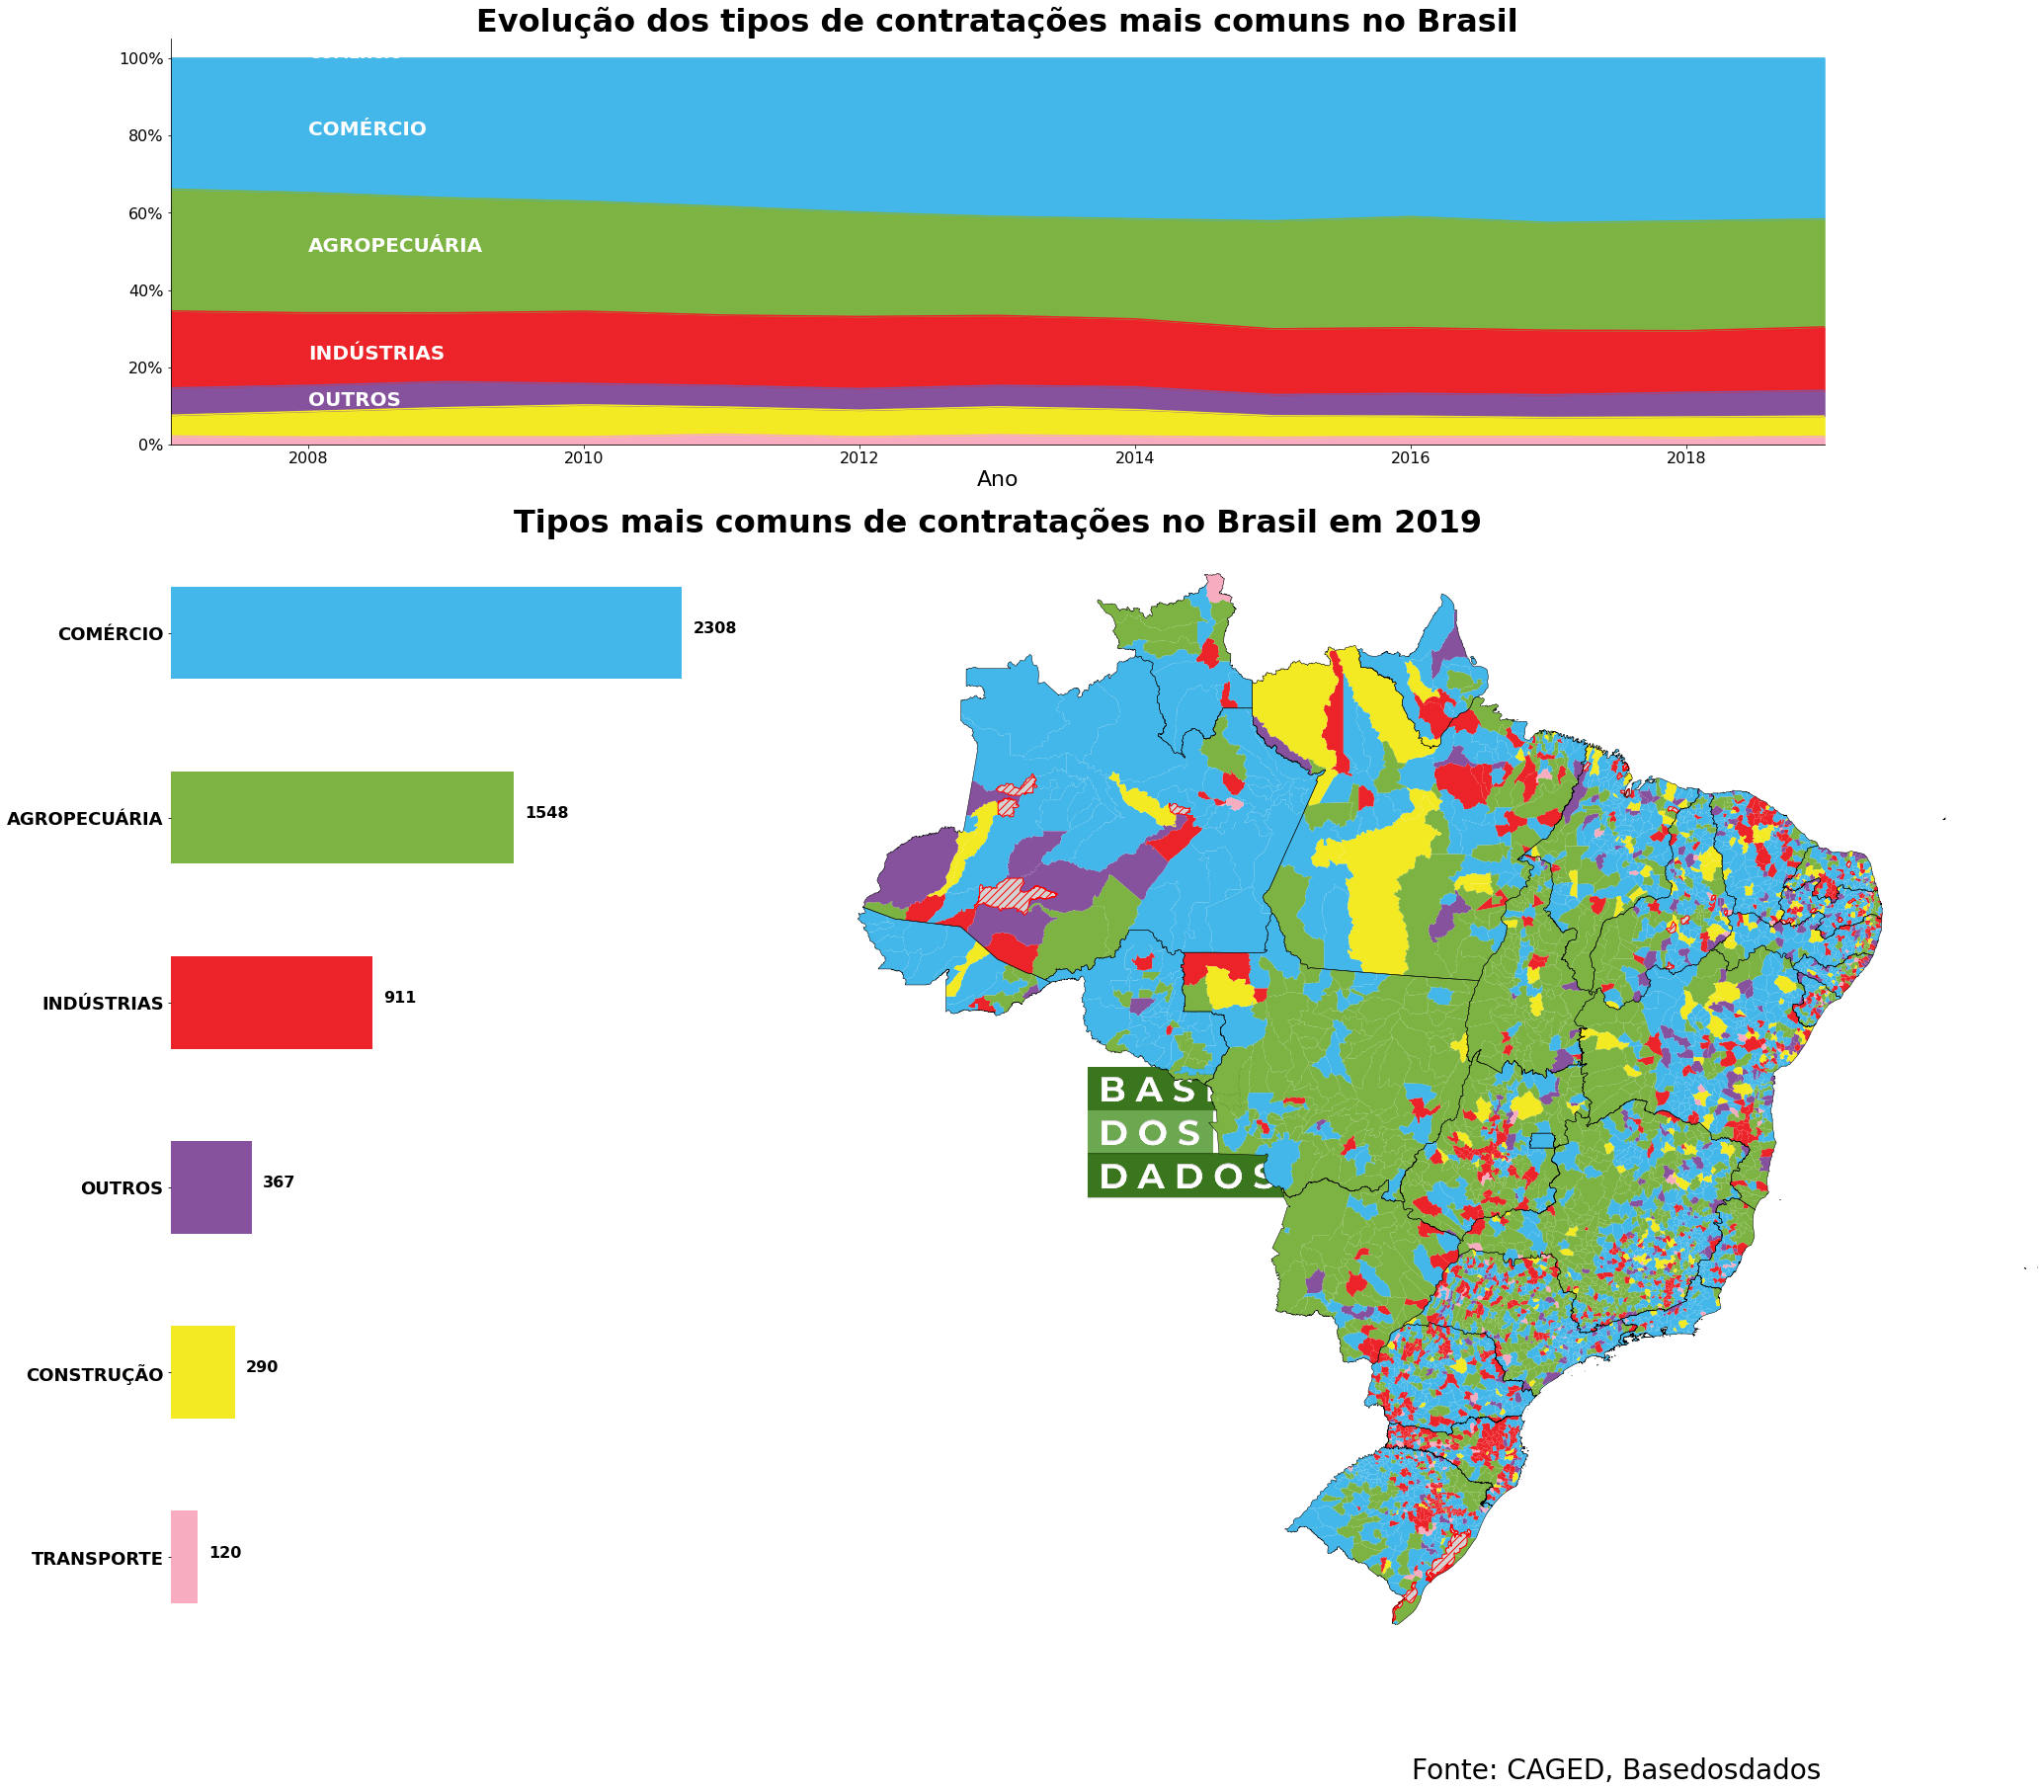

In [247]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(30,30))
grid = plt.GridSpec(3,2, width_ratios=[1,1.8] ,height_ratios=[1,0.000001,2.5])

fig = plt.figure(figsize=(30,30))
ax3  = plt.subplot(grid[0,:2])
axtitle  = plt.subplot(grid[1,:2])
ax2  = plt.subplot(grid[2,:1])
ax1 = plt.subplot(grid[2, 1:])

pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0, pos.width, pos.height+0.044])

pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0, pos.width+0.1, pos.height+0.04])

axtitle.set_title('Tipos mais comuns de contratações no Brasil em 2019', fontsize=32,fontweight='bold')
axtitle.axis('off')
# divider = make_axes_locatable(ax)

# ax1.set_title('Tipos mais comuns de contratações no Brasil em 2019', fontsize=22,fontweight='bold')

colors = [
    "#7cb342",
    "#43B7E9",
    "#F4EA24",
    "#EC2328",
    "#86529E",
    "#F7ACC0",
    
]

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

legend_kwds = {
    'loc': 'best',
    'fontsize':18

}

remove_ilhas = (df['id_municipio']!=3205309) |(df['id_municipio']!=2605459)
mask = (df['name_region']=='Centro Oeste')
df.plot(column='divisao_economica',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
#         legend=True,
        legend_kwds=legend_kwds,
        missing_kwds=missing_kwds
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 0.5, ax=ax1)

ax1.axis('off')




# for idx, row in mun_votos.iterrows():
#     plt.annotate(s=str(row['votos']), xy=row['coords'],fontsize=15,
#                  horizontalalignment='center', color='#ffffff')

px_bar_colors = [
    "#43B7E9",
    "#7cb342",
    "#EC2328",
        "#86529E",
    "#F4EA24",
    "#F7ACC0",
    
]

df_count.plot.barh(
    x='divisao_economica',
    y='count',
    ax=ax2,
    color=px_bar_colors[::-1],
    legend=False
)

# ax2.set_title('Tipos mais comuns de contratações no Brasil em 2019', fontsize=20,fontweight='bold')


ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=18)
for tick in ax2.get_yticklabels():
    tick.set_weight("bold")
    
    
ax2.set_xlabel('Quantidade de municípios', fontsize=20)
ax2.set_ylabel('', fontsize=20)

ax2.axes.get_xaxis().set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)




for y, x  in enumerate(df_count['count']):
    ax2.text(x+50 , y, str(x), color='black', fontweight='bold', fontsize=16)






px_area_colors = [
    "#F7ACC0",
    "#F4EA24",
    "#86529E",
    "#EC2328",
    "#7cb342",
    "#43B7E9",
]
cols = ['ano', 'TRANSPORTE', 'CONSTRUÇÃO','OUTROS', 'INDÚSTRIAS', 'AGROPECUÁRIA', 'COMÉRCIO']

caged_graph[cols].plot.area(
    x='ano',
    color=px_area_colors,
    ax=ax3,
    legend=False

)
ax3.set_title('Evolução dos tipos de contratações mais comuns no Brasil', fontsize=32,pad=0,fontweight='bold')

ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.set_xlabel('Ano', fontsize=22)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.text(2008 ,100, 'COMÉRCIO' ,color='white', fontweight='bold', fontsize=16)
ax3.annotate('COMÉRCIO', (2008, 80),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.annotate('AGROPECUÁRIA', (2008, 50),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.annotate('INDÚSTRIAS', (2008, 22),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.annotate('OUTROS', (2008, 10),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.margins(x=0, y=0)


ax2.text(5600,-1.20,'Fonte: CAGED, Basedosdados',fontsize=28)


logo=image.imread("bd_logo.png")
# You have to add your own logo, this is in my own folder
addLogo = OffsetImage(logo, zoom=0.25)
#addLogo.set_zorder(100)
addLogo.set_offset((1100,600))
ax2.add_artist(addLogo)

ax1.margins(x=0, y=0)

plt.savefig('tipos_contratacoes.png', dpi=300)

## SALARIO

In [234]:
query = """
WITH caged as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    admitidos_desligados,
    salario_mensal
  FROM `basedosdados.br_me_caged.microdados_antigos`
) 

SELECT 
  ano,
  id_municipio,
  sigla_uf,
  AVG(salario_mensal) as media_salario,
  APPROX_QUANTILES(salario_mensal,1000)[OFFSET(500)] as mediana_salario
FROM caged
WHERE admitidos_desligados=1
GROUP BY 1,2,3
"""
caged_salario = bd.read_sql(query, billing_project_id='basedosdados-dev')
caged_salario_2019 = caged_salario[caged_salario['ano']==2019]

Downloading: 100%|██████████| 71321/71321 [00:04<00:00, 16105.58rows/s]


In [236]:
caged_salario_2019
dd = pd.merge(caged_salario_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
dd = gpd.GeoDataFrame(dd).sort_values(by='media_salario', ascending=False)

In [ ]:
dd.plot(column='media_salario')

In [241]:
def get_mapa_salario(ax,var):
    dd = pd.merge(caged_salario_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
    dd = gpd.GeoDataFrame(dd).sort_values(by=var, ascending=False)

    colors = [
         "#E66E52",
        "#F3A061",
        "#E8C36A",
        "#87D397",
        "#22926E",
        "#184C5F",
    ]

    legenda = [
        'entre 0 e 1.000',
        ' 1.000 e 1.200',
        ' 1.200 e 1.300',
        ' 1.300 e 1.400',
        ' 1.400 e 1.800',
        'mais de 1.800'
    ]


#     fig = plt.figure(figsize=(30,40))
#     ax  = fig.add_subplot(1,1,1)
    # divider = make_axes_locatable(ax)
    if var=='media_salario':
        t = 'Média'
    else:
        t = 'Mediana'
    ax.set_title(f'{t} Salarial no Brasil em 2019', fontsize=46,pad=100,fontweight='bold')

    missing_kwds = {
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "NÃO CONSTA",
        }

    # Create a colormap using only the colours in this group

    missing_kwds = {
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "NÃO CONSTA",
        }

    cmap = ListedColormap(colors)
    colorscale = cmap

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
    vmax = dd[var].values.max()
    vmin = dd[var].values.min()
    norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
    fig.add_axes(ax_cb)
    labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
    cbar = fig.colorbar(mappable, cax=ax_cb, ticks=labels,orientation='horizontal')
    cbar.ax.set_xticklabels(legenda)
    cbar.ax.tick_params(labelsize=28) 


    mask = (df['sigla_uf']=='BA')
    dd.plot(column=var,
            ax=ax,
    #         legend=True,
#             legend_kwds = legend_kwds,
            cmap=cmap,
            missing_kwds=missing_kwds,
            scheme='user_defined', 
            classification_kwds={'bins':[1000,1200,1300,1400,1800,7200]},
           )

    states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)

    ax.axis('off')

    # for idx, row in mun_votos.iterrows():
    #     plt.annotate(s=str(row['votos']), xy=row['coords'],fontsize=15,
    #                  horizontalalignment='center', color='#ffffff')
    # scale_bar(ax, 100, location=(0.5,0.01))
    
    
    ax.text(-38.7,-38.7,'Fonte: CAGED, basedosdados',fontsize=28)


    logo=image.imread("bd_logo.png")
    # You have to add your own logo, this is in my own folder
    addLogo = OffsetImage(logo, zoom=0.25)
    #addLogo.set_zorder(100)
    addLogo.set_offset((1240,940))
    ax.add_artist(addLogo)
    
    plt.savefig(f'{var}.png', dpi=300)

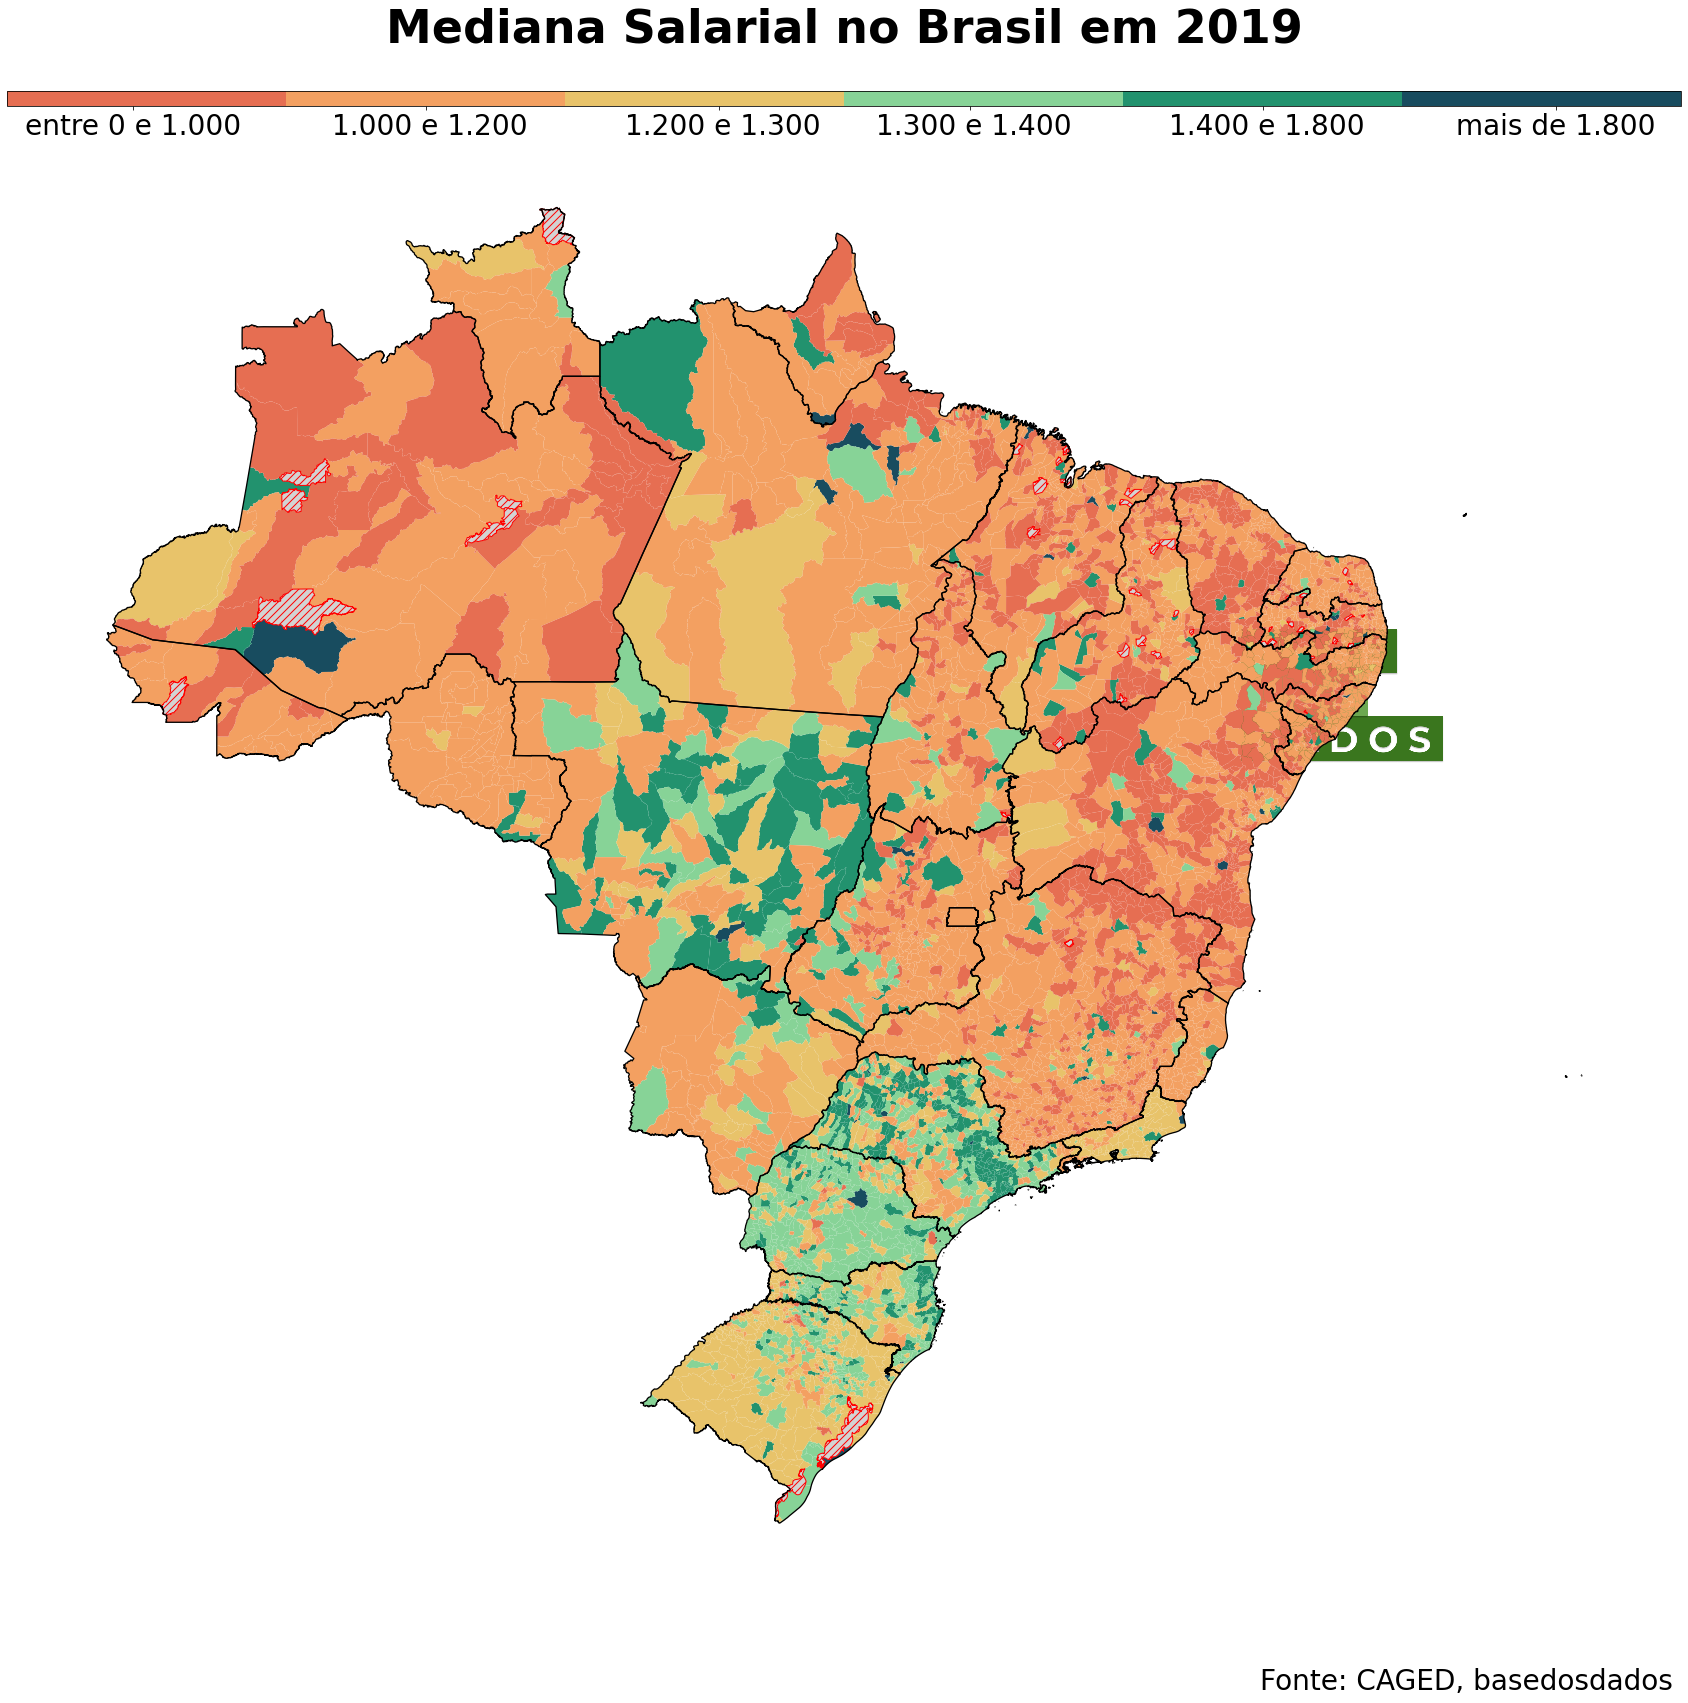

In [242]:
fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)
get_mapa_salario(ax, 'mediana_salario')